# Download neural data

This template walks through a simple example of downloading raw time series and spectrogram data, given some time interval of interest. After we obtain the raw time series, we will also locally compute our own spectrogram and compare to the API spectrogram.

We utilize the Rune Stream API and Python package `runeq`. Full API documentation can be found here: https://docs.runelabs.io/. Information about the Python package can be found here: https://runeq.readthedocs.io/en/latest/.

In [1]:
import io
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from runeq import Config, stream
from scipy import stats

## Functions for pulling raw time series and spectrogram data with the API

`get_neural_time_series` and `get_spectrogram` will pull data with the Stream API and save as CSVs. These wrapper functions can be easily modified to access the other API endpoints.

In [2]:
def make_full_df(accessor):
    """
    Loop through pages of API calls and append to a single dataframe
    using the CSV endpoint

    Inputs: accessor
    Outputs: dataframe
    """

    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    return df

def get_neural_time_series(client, params, save_filepath=None):
    """
    Makes API calls for raw time series data
    Saves as a CSV

    Inputs: client
            API parameters (see API documentation)
            save_filepath, ex. './new_time_series_file'
    Outputs: saved CSV file
    """

    accessor = client.LFP(**params)
    df = make_full_df(accessor)

    # save dataframe to a csv if filepath is specified
    if save_filepath:
        df.to_csv(save_filepath, index=False)

    return df


def get_spectrogram(client, params, save_filepath=None):
    """
    Makes API calls for spectrogram data
    Saves separate CSV's for every channel

    Inputs: client
            API parameters (see API documentation)
            save_filepath, ex. './new_spectrogram_file'
    Outputs: saved CSV file
    """

    accessor = client.LFP(expression='spectrogram(lfp)', **params)
    df = make_full_df(accessor)

    # save dataframe to a csv if filepath is specified
    if save_filepath:
        df.to_csv(save_filepath, index=False)

    return df

## 1. Initialize API credentials

First initialize your API credentials. These credentials are analogous to having a username/password for accessing patient data. You can set up an access token for read access to all patients within your organization. See our [API doc](https://docs.runelabs.io/stream/#section/Overview/Authentication) for instructions on how to set this up.

Next, set up a .yaml file with your token ID and secret. This is text file that will store your credentials. See our [`runeq` quickstart](https://runeq.readthedocs.io/en/latest/pages/quickstart.html#configuration) for how to set this up.

In [3]:
# set up a client

cfg = Config()
client = stream.V1Client(cfg)

This client object can now be used to make API calls. Next, we will specify the parameters for our API calls. Check out the full API documentation for required vs. optional parameters per endpoint.

## 2. Specify endpoint parameters and retrieve neural time series data

In this example, we will obtain all channel, sensor, and anatomy data for this patient-device combination.

In [4]:
params = {
    'patient_id': 'rcs07',
    'device_id': 'NPC700403H',
    'start_time': 1613167200.0,
    'end_time': 1613168400.0
}

If you do not know the unix time stamps, you can convert from date time. For example:
```
datetime.datetime(2020, 1, 1).timestamp()
```

You can also check for neural time series data with a specific recording configuration by including the parameters `sensor`, `channel`, and `anatomy`. `sensor` refers to the bipolar recording electrode pair (ex. 1-3), `channel` is the internal device channel number that was used for recording (on the RC+S, this is a number between 1-4), and `anatomy` refers to the location of the recorded signal (ex. M1 or STN). For example, to download data recorded using sensor 0-2 (i.e., voltage between electrodes 0 and 2 of a DBS lead):
```
params = {
    'device_id': 'NPC700403H',
    'start_time': 1584646104,
    'end_time': 1584647285,    
    'sensor': '0-2',
}
```
By default, leaving any of the parameters unspecified will pull all available data for that parameter.

We will pass the client, our parameters, and a file path for saving our data into our functions above to obtain the CSV data. Be sure to change the file directories below to match your own file structure.

In [5]:
# specify base path for saving data

BASE_PATH = '~/Documents/api_data/'

By filling out the optional `save_filepath` parameter, we can save the dataframe as a csv file in the directory specified by `BASE_PATH`.

In [6]:
# retrieve neural time series data

time_series = get_neural_time_series(
    client,
    params,
    save_filepath=os.path.join(BASE_PATH, 'nb01_ex01_neural_time_series')
)

If saving the dataframe as a csv file is unnecessary, the optional `save_filepath` parameter can be left unspecified. For example,
```
time_series = get_neural_time_series(
    client,
    params
)
```

## 3. Load CSV's (if desired) and clean dataframes

The function above both saves the data to CSV's and returns the dataframe. If we wanted to directly load the time series csv files as dataframes, we could read them with `pd.read_csv`.
```
time_series = pd.read_csv(
    os.path.join(BASE_PATH, 'nb01_ex01_neural_time_series')
)
```

`time_series` is a stacked dataframe, containing timestamp, algorithm, anatomy, channel, sensor, and potential as the columns, with the LFP data contained in the potential column.

In [8]:
time_series

,timestamp,algorithm,anatomy,channel,sensor,potential
0,1.613167e+09,medtronic-rcs-2,M1,2,0-2,-0.000209
1,1.613167e+09,medtronic-rcs-2,M1,2,0-2,-0.000209
2,1.613167e+09,medtronic-rcs-2,M1,2,0-2,-0.000217
3,1.613167e+09,medtronic-rcs-2,M1,2,0-2,-0.000217
4,1.613167e+09,medtronic-rcs-2,M1,2,0-2,-0.000238
...,...,...,...,...,...,...
4702155,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000176
4702156,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000061
4702157,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000061
4702158,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000045


In order to examine LFP data for channels, we can apply a dataframe [pivot](https://pandas.pydata.org/docs/user_guide/reshaping.html) in order to reshape the data.

In [9]:
df = time_series.pivot_table(index='timestamp', columns='channel', values='potential')
df.columns.name = None
time_series_channels = df.reset_index()
time_series_channels

,timestamp,0,1,2,3
0,1.613167e+09,-0.000215,-0.000201,-0.000209,-0.000151
1,1.613167e+09,-0.000110,-0.000097,-0.000217,-0.000153
2,1.613167e+09,-0.000171,-0.000156,-0.000238,-0.000133
3,1.613167e+09,-0.000269,-0.000253,-0.000237,-0.000136
4,1.613167e+09,-0.000199,-0.000183,-0.000229,-0.000148
...,...,...,...,...,...
587765,1.613168e+09,-0.000047,-0.000034,-0.000222,-0.000119
587766,1.613168e+09,-0.000169,-0.000155,-0.000226,-0.000123
587767,1.613168e+09,-0.000190,-0.000176,-0.000212,-0.000136
587768,1.613168e+09,-0.000076,-0.000061,-0.000210,-0.000144


Similarly, we can reshape the dataframe to view anatomy or sensor data.

In [10]:
df = time_series.pivot_table(index='timestamp', columns='anatomy', values='potential')
df.columns.name = None
time_series_anatomy = df.reset_index()
time_series_anatomy

,timestamp,M1,STN
0,1.613167e+09,-0.000180,-0.000208
1,1.613167e+09,-0.000185,-0.000103
2,1.613167e+09,-0.000185,-0.000164
3,1.613167e+09,-0.000187,-0.000261
4,1.613167e+09,-0.000188,-0.000191
...,...,...,...
587765,1.613168e+09,-0.000171,-0.000041
587766,1.613168e+09,-0.000174,-0.000162
587767,1.613168e+09,-0.000174,-0.000183
587768,1.613168e+09,-0.000177,-0.000068


In [11]:
df = time_series.pivot_table(index='timestamp', columns='sensor', values='potential')
df.columns.name = None
time_series_sensor = df.reset_index()
time_series_sensor

,timestamp,0-2,1-3
0,1.613167e+09,-0.000209,-0.000189
1,1.613167e+09,-0.000217,-0.000120
2,1.613167e+09,-0.000238,-0.000154
3,1.613167e+09,-0.000237,-0.000219
4,1.613167e+09,-0.000229,-0.000176
...,...,...,...
587765,1.613168e+09,-0.000222,-0.000067
587766,1.613168e+09,-0.000226,-0.000149
587767,1.613168e+09,-0.000212,-0.000167
587768,1.613168e+09,-0.000210,-0.000094


## 4. Plot spectrogram and neural time series data

In this example, we will plot the spectrogram and neural time series of a specific combination of parameters. Here, we are pulling data from channel 1, STN, and sensor 1-3. (While a chosen electrode pair is unlikely to change anatomic locations, this example demonstrates the potential usage of combined parameters.)

In [12]:
params_specific = {
    'patient_id': 'rcs07',
    'device_id': 'NPC700403H',
    'start_time': 1613167200.0,
    'end_time': 1613168400.0,
    'channel': '1',
    'anatomy': 'STN',
    'sensor': '1-3',
}

In [13]:
# Make API calls for spectrogram data
spectro = get_spectrogram(
    client,
    params_specific,
)

The `spectro` dataframe contains timestamp, algorithm, anatomy, sensor, and frequency columns.

In [14]:
spectro

,timestamp,algorithm,anatomy,channel,sensor,f_0hz,f_1hz,f_2hz,f_3hz,f_4hz,...,f_115hz,f_116hz,f_117hz,f_118hz,f_119hz,f_120hz,f_121hz,f_122hz,f_123hz,f_124hz
0,1.613167e+09,medtronic-rcs-2,STN,1,1-3,2.354797e-14,4.859611e-11,2.265072e-11,4.615209e-12,4.169860e-12,...,3.063254e-12,1.584337e-11,7.331220e-12,2.986040e-11,6.016127e-11,5.344045e-12,4.837241e-11,8.703600e-11,3.848099e-11,5.161828e-11
1,1.613167e+09,medtronic-rcs-2,STN,1,1-3,4.643639e-13,2.665826e-11,1.486394e-11,1.525184e-12,2.360587e-12,...,1.054797e-11,6.719114e-12,7.874065e-12,5.491521e-12,3.733918e-11,1.394359e-11,5.677457e-11,8.381871e-12,2.648234e-12,5.747318e-11
2,1.613167e+09,medtronic-rcs-2,STN,1,1-3,1.456002e-13,7.091267e-12,1.275881e-11,1.368933e-11,1.988039e-12,...,1.072695e-12,2.636375e-12,1.655508e-11,3.292181e-12,2.318171e-11,4.414209e-11,3.192115e-12,3.786568e-11,2.034587e-11,1.678310e-11
3,1.613167e+09,medtronic-rcs-2,STN,1,1-3,6.296906e-14,3.605587e-11,4.772606e-12,4.937287e-13,2.718781e-12,...,2.892222e-12,5.621806e-12,6.968113e-13,5.451283e-12,8.205417e-12,9.629538e-12,1.986258e-12,4.309222e-11,1.222424e-11,1.802261e-11
4,1.613167e+09,medtronic-rcs-2,STN,1,1-3,1.256593e-13,6.521553e-11,1.161628e-11,1.786128e-12,8.430678e-12,...,9.022396e-12,3.870406e-11,3.267088e-12,4.663520e-12,1.407417e-11,1.822423e-11,7.388932e-12,9.638196e-12,1.708191e-11,8.177124e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4076,1.613168e+09,rune-psd-spectrogram-1hz-v1,STN,1,1-3,4.430845e-13,5.018075e-11,1.113996e-12,1.449064e-11,1.391037e-12,...,1.027662e-12,1.573581e-11,1.151758e-11,4.278035e-11,2.251721e-11,1.698110e-11,1.341902e-12,9.091719e-11,1.436914e-11,1.003042e-10
4077,1.613168e+09,rune-psd-spectrogram-1hz-v1,STN,1,1-3,2.905249e-13,9.006063e-11,2.119930e-11,1.003170e-11,5.948541e-12,...,1.002605e-11,1.440934e-11,1.405964e-11,5.543875e-11,8.642087e-13,5.356939e-12,1.471876e-12,1.096961e-10,7.461638e-11,1.056286e-11
4078,1.613168e+09,rune-psd-spectrogram-1hz-v1,STN,1,1-3,1.597640e-12,1.372652e-10,8.086904e-11,5.340931e-12,9.661173e-12,...,9.911944e-12,2.313426e-11,6.486076e-12,1.024305e-11,5.964444e-12,1.638816e-11,3.145539e-11,4.448268e-11,1.700000e-11,6.254181e-11
4079,1.613168e+09,rune-psd-spectrogram-1hz-v1,STN,1,1-3,1.204579e-13,1.524816e-11,1.093255e-11,9.070533e-12,1.221459e-11,...,1.447655e-11,3.009782e-11,1.580906e-11,8.797185e-12,1.029806e-11,2.384504e-11,2.860679e-11,6.867695e-12,7.089351e-12,2.669795e-10


After examining the data, we can see that multiple algorithms have been used to analyze the spectrogram data. We confirm this below:

In [15]:
print('Algorithms: ')
print(spectro['algorithm'].unique())

Algorithms: 
['medtronic-rcs-2' 'rune-psd-spectrogram-1hz-v1']


In some instances, multiple algorithm tags may indicate options (e.g., spectrograms calculated using different parameters or functions). Otherwise, they indicate updates that have been implemented in the Rune platform. For most use cases, leaving the algorithm parameter empty and accepting the default value is ideal.

Because both algorithms are exposed here, we will specify the most recent algorithm: `medtronic-rcs-2`.

In [16]:
# retrieve neural time series data
time_series = get_neural_time_series(
    client,
    params_specific
)

# specify spectrogram algorithm
params_specific['algorithm'] = 'medtronic-rcs-2'

# retrieve spectrogram data
spectro = get_spectrogram(
    client,
    params_specific
)

In [17]:
time_series

,timestamp,algorithm,anatomy,channel,sensor,potential
0,1.613167e+09,medtronic-rcs-2,STN,1,1-3,-0.000201
1,1.613167e+09,medtronic-rcs-2,STN,1,1-3,-0.000201
2,1.613167e+09,medtronic-rcs-2,STN,1,1-3,-0.000097
3,1.613167e+09,medtronic-rcs-2,STN,1,1-3,-0.000097
4,1.613167e+09,medtronic-rcs-2,STN,1,1-3,-0.000156
...,...,...,...,...,...,...
1175535,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000176
1175536,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000061
1175537,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000061
1175538,1.613168e+09,medtronic-rcs-2,STN,1,1-3,-0.000045


In [18]:
spectro

,timestamp,algorithm,anatomy,channel,sensor,f_0hz,f_1hz,f_2hz,f_3hz,f_4hz,...,f_115hz,f_116hz,f_117hz,f_118hz,f_119hz,f_120hz,f_121hz,f_122hz,f_123hz,f_124hz
0,1.613167e+09,medtronic-rcs-2,STN,1,1-3,2.354797e-14,4.859611e-11,2.265072e-11,4.615209e-12,4.169860e-12,...,3.063254e-12,1.584337e-11,7.331220e-12,2.986040e-11,6.016127e-11,5.344045e-12,4.837241e-11,8.703600e-11,3.848099e-11,5.161828e-11
1,1.613167e+09,medtronic-rcs-2,STN,1,1-3,4.643639e-13,2.665826e-11,1.486394e-11,1.525184e-12,2.360587e-12,...,1.054797e-11,6.719114e-12,7.874065e-12,5.491521e-12,3.733918e-11,1.394359e-11,5.677457e-11,8.381871e-12,2.648234e-12,5.747318e-11
2,1.613167e+09,medtronic-rcs-2,STN,1,1-3,1.456002e-13,7.091267e-12,1.275881e-11,1.368933e-11,1.988039e-12,...,1.072695e-12,2.636375e-12,1.655508e-11,3.292181e-12,2.318171e-11,4.414209e-11,3.192115e-12,3.786568e-11,2.034587e-11,1.678310e-11
3,1.613167e+09,medtronic-rcs-2,STN,1,1-3,6.296906e-14,3.605587e-11,4.772606e-12,4.937287e-13,2.718781e-12,...,2.892222e-12,5.621806e-12,6.968113e-13,5.451283e-12,8.205417e-12,9.629538e-12,1.986258e-12,4.309222e-11,1.222424e-11,1.802261e-11
4,1.613167e+09,medtronic-rcs-2,STN,1,1-3,1.256593e-13,6.521553e-11,1.161628e-11,1.786128e-12,8.430678e-12,...,9.022396e-12,3.870406e-11,3.267088e-12,4.663520e-12,1.407417e-11,1.822423e-11,7.388932e-12,9.638196e-12,1.708191e-11,8.177124e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,1.613168e+09,medtronic-rcs-2,STN,1,1-3,6.388836e-14,4.067868e-11,3.849894e-11,4.628323e-12,1.087848e-11,...,9.259234e-12,1.699889e-11,2.021343e-12,1.536477e-11,8.100697e-11,1.165199e-12,6.656377e-11,1.702664e-10,1.605711e-11,5.577804e-11
1352,1.613168e+09,medtronic-rcs-2,STN,1,1-3,1.420061e-14,2.639865e-11,1.173797e-11,1.354238e-11,2.327249e-12,...,4.175225e-12,2.567036e-12,1.613579e-11,1.542464e-11,8.657006e-13,6.303015e-12,8.385435e-12,1.461593e-11,3.392187e-11,5.051310e-12
1353,1.613168e+09,medtronic-rcs-2,STN,1,1-3,4.430845e-13,5.018075e-11,1.113996e-12,1.449064e-11,1.391037e-12,...,1.027662e-12,1.573581e-11,1.151758e-11,4.278035e-11,2.251721e-11,1.698110e-11,1.341902e-12,9.091719e-11,1.436914e-11,1.003042e-10
1354,1.613168e+09,medtronic-rcs-2,STN,1,1-3,1.597640e-12,1.372652e-10,8.086904e-11,5.340931e-12,9.661173e-12,...,9.911944e-12,2.313426e-11,6.486076e-12,1.024305e-11,5.964444e-12,1.638816e-11,3.145539e-11,4.448268e-11,1.700000e-11,6.254181e-11


Now, we can plot the time series and spectrogram data.

Note: In this notebook, plots are static. Use magic function `%matplotlib notebook`  or `%matplotlib widget` for interactive zooming and panning.


In [19]:
# create an array with only the power values
Sxx = spectro.drop(labels=['timestamp','algorithm','anatomy','channel','sensor'], axis=1).values
Sxx = Sxx.transpose()

# z-score for plotting (optional)
Sxx = stats.zscore(Sxx, axis=0)

# obtain frequencies from column headers, drop metadata columns and 0 hz
f = [int(freq.strip('f_').strip('hz')) for freq in list(spectro.keys()[5:])]

# change unix to date time stamps for plotting
t = pd.to_datetime(spectro.timestamp, unit='s').astype(int)

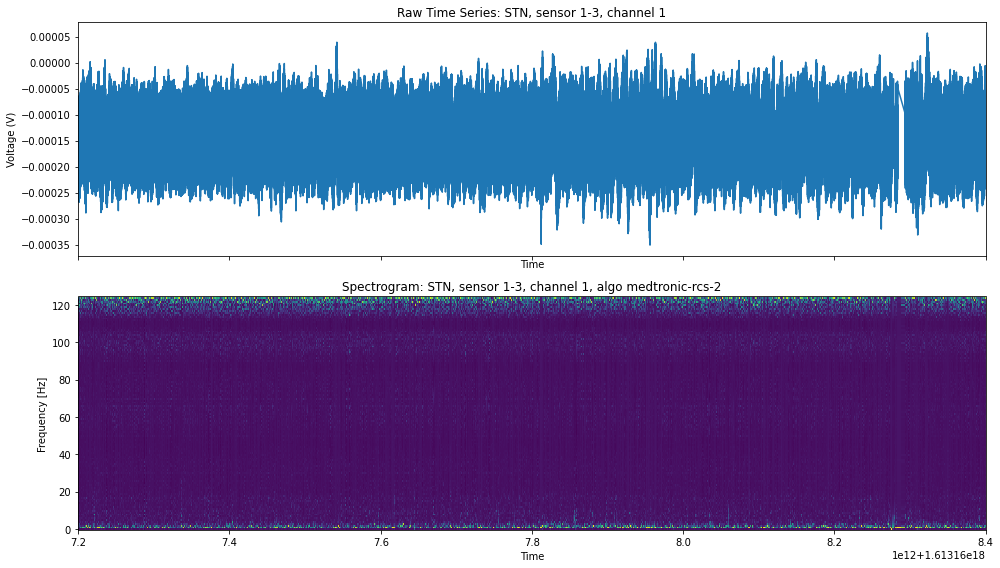

In [20]:
# plot
fig, ax = plt.subplots(2, figsize=(14, 8), sharex=True)

plot_time = pd.to_datetime(time_series.timestamp, unit='s').astype(int)
ax[0].plot(plot_time, time_series['potential'])
ax[0].set(xlabel='Time', ylabel='Voltage (V)')
ax[0].set_title('Raw Time Series: STN, sensor 1-3, channel 1')

ax[1].pcolormesh(t, f, Sxx, shading='auto')
ax[1].set(xlabel='Time', ylabel='Frequency [Hz]')
ax[1].set_title('Spectrogram: STN, sensor 1-3, channel 1, algo medtronic-rcs-2')

plt.tight_layout()

## Summary

Using the Rune API and Python package `runeq`, we obtained raw time series and spectrogram data for a time interval of interest. 